In [130]:
import numpy as np
# import statsmodels.api as sm

In [131]:
# pip install statsmodels

In [132]:
# import numpy as np
# import statsmodels.api as sm

# # Generate some sample data
# np.random.seed(0)
# X = np.random.randn(100, 1)
# y = 2 * X.squeeze() + np.random.randn(100)

# # Perform quantile regression for median (quantile=0.5)
# quantile = 0.5
# quant_reg = sm.QuantReg(y, sm.add_constant(X))
# quant_reg_results = quant_reg.fit(q=quantile)

# # Print the regression coefficients
# print("Intercept:", quant_reg_results.params[0])
# print("Coefficient:", quant_reg_results.params[1])

In [133]:
n_train = n_calib = n_test = 500

# Generate synthetic training data
np.random.seed(0)
X_train = np.random.rand(n_train, 1) * 10
y_train = 2 * X_train.squeeze() + np.random.randn(n_train)

# Generate synthetic calibration data
X_calib = np.random.randn(n_calib, 1) * 10
y_calib = 2 * X_calib.squeeze() + np.random.randn(n_calib)

# Generate synthetic test data
X_test = np.random.randn(n_test, 1) * 10
y_test = 2 * X_test.squeeze() + np.random.randn(n_test)

In [134]:
X_train.shape, y_train.shape, X_calib.shape, y_calib.shape, X_test.shape, y_test.shape

((500, 1), (500,), (500, 1), (500,), (500, 1), (500,))

In [135]:
import matplotlib.pyplot as plt

def plot_model(quant_reg_model, quantile, X, y):
    '''
     Plot the resulting quantile regression model along with the original data:
    '''
    # # Plot the original data
    # plt.scatter(X, y, color='blue', label='Original data')

    # # Plot the regression line
    # x_values = np.linspace(X.min(), X.max(), 500)
    # y_values = quant_reg_model.params[0] + quant_reg_model.params[1] * x_values
    # plt.plot(x_values, y_values, color='red', label='Quantile regression')

    # plt.xlabel('X')
    # plt.ylabel('y')
    # plt.title(f'Quantile Regression (q={quantile})')
    # plt.legend()
    # plt.show()

    # Plotting the data points
    plt.scatter(X, y, color='blue', label='Training data')

    # Plotting the model predictions
    x_values = np.linspace(0, 10, 200).reshape(-1, 1)
    y_pred = quant_reg_model.predict(x_values)
    plt.plot(x_values, y_pred, color='red', label=f'GradientBoostingRegressor (q={quantile})')

    # Adding labels and legend
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Gradient Boosting Regressor')
    plt.legend()

    # Display the plot
    plt.show()


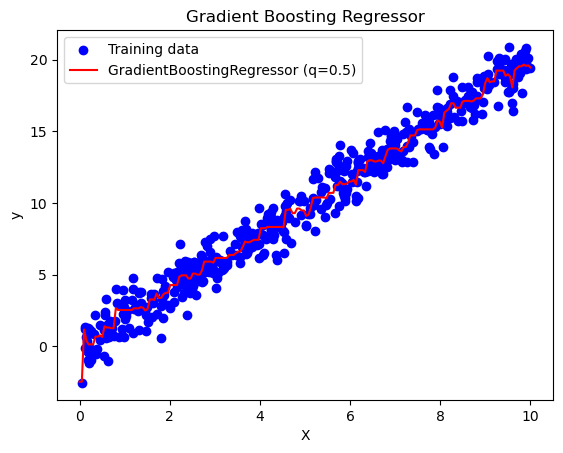

In [136]:
# Perform quantile regression for median (0.5-th quantile)
median = 0.5
# quant_reg = sm.QuantReg(y_train, sm.add_constant(X_train))
quant_reg = GradientBoostingRegressor(loss='quantile',alpha=median)
qr_median = quant_reg.fit(X_train, y_train)
plot_model(qr_median, median, X_train, y_train)

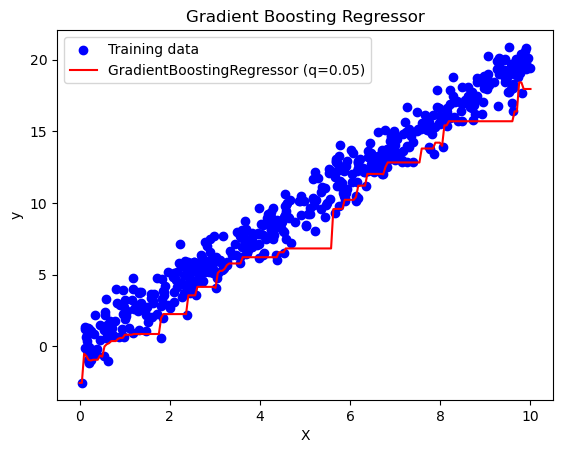

In [137]:
# Perform quantile regression for 0.05-th quantile
q_alpha_low = 0.05
quant_reg = GradientBoostingRegressor(loss='quantile', alpha=q_alpha_low)
q_hat_alpha_low_model = quant_reg.fit(X_train, y_train)
plot_model(q_hat_alpha_low_model, q_hat_alpha_low, X_train, y_train)

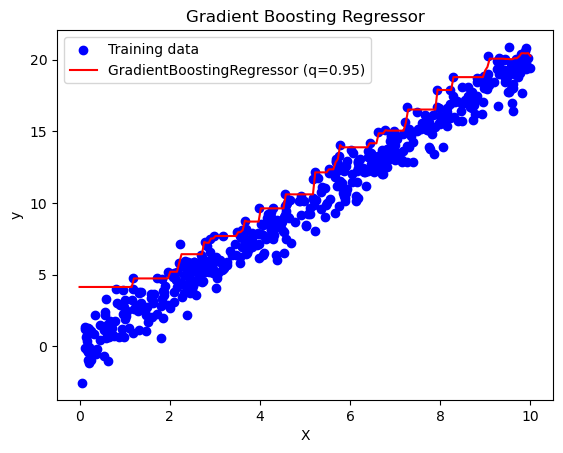

In [138]:
# Perform quantile regression for 0.95-th quantile
alpha_high = 0.95
quant_reg = GradientBoostingRegressor(loss='quantile', alpha=alpha_high)
q_hat_alpha_high_model = quant_reg.fit(X_train, y_train)
plot_model(q_hat_alpha_high_model, q_hat_alpha_high, X_train, y_train)

# CQR (from scratch)

## Compute $E_i$ values

In [139]:
def cqr_score(q_low, q_high, y):
    return np.maximum(q_low-y, y-q_high)

(
    cqr_score(1.0, 3.5, 0.0), 
    cqr_score(1.0, 3.5, 1.0), 
    cqr_score(1.0, 3.5, 1.5),
    cqr_score(1.0, 3.5, 3.0), 
    cqr_score(1.0, 3.5, 4.0)
)

(1.0, 0.0, -0.5, -0.5, 0.5)

In [140]:
# q_low = q_hat_alpha_low_model.predict(sm.add_constant(X_calib))
# q_high = q_hat_alpha_high_model.predict(sm.add_constant(X_calib))

q_low = q_hat_alpha_low_model.predict(X_calib)
q_high = q_hat_alpha_high_model.predict(X_calib)

cqr_scores =  cqr_score(q_low, q_high, y_calib)

In [141]:
cqr_scores[0]

-1.6651598402412837

In [142]:
q_low[0], q_high[0], q_low[0]-y_calib[0], y_calib[0]-q_high[0]

(15.699481955096363,
 20.066569733611267,
 -2.70192793827362,
 -1.6651598402412837)

In [143]:
cqr_scores

array([-1.66515984e+00,  7.95941858e+00, -7.58524440e-01,  1.24253569e+01,
        9.96793412e+00, -1.66055084e+00, -1.30373098e+00, -9.68435103e-02,
        2.59160623e+01,  1.87508815e+01,  1.44374712e+01,  3.02507104e+01,
        3.23979552e+01,  5.94037030e+00,  2.71423613e+01,  1.02314965e+01,
        2.24861874e-01,  1.02289556e+00,  1.49532228e+01,  1.56719138e+01,
        6.84876565e+00,  2.04234334e+01,  1.63271504e+00,  6.11074371e+00,
        1.39086654e+01,  2.69446587e+01,  1.73558297e-02,  3.91063004e+01,
        2.24195970e+01, -1.22111580e+00, -3.11515977e+00,  4.13374729e+00,
        1.52058773e+00,  1.68230972e+00,  2.40159708e+01,  4.11264562e+00,
        7.33927736e+00, -1.22877125e+00, -1.58308931e+00,  2.71435806e+01,
        2.68104121e+00,  1.65136917e+00,  3.04494861e-02,  8.61961378e+00,
        1.22620750e+01,  5.14440393e+00,  3.19930299e-01,  2.44990739e+01,
        4.15816803e+00,  1.33080972e+01,  1.67658516e+01,  1.21741342e+01,
        1.28774730e+01,  

In [144]:
np.sum(cqr_scores >= 0, axis=0)

317

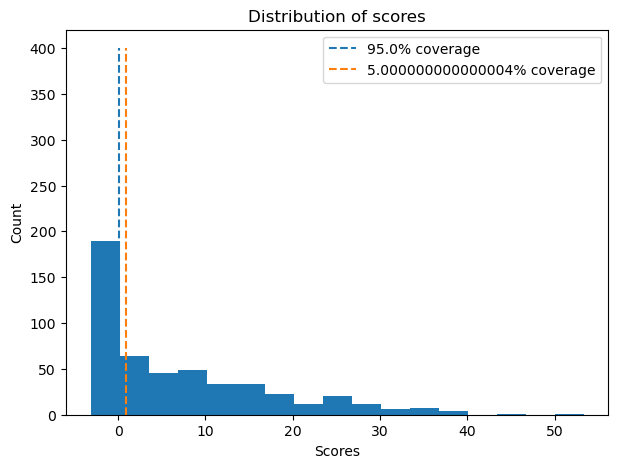

In [145]:
def plot_scores(alphas, scores, quantiles):
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c"}
    plt.figure(figsize=(7, 5))
    plt.hist(scores, bins="auto")
    for i, quantile in enumerate(quantiles):
        plt.vlines(
            x=quantile,
            ymin=0,
            ymax=400,
            color=colors[i],
            ls="dashed",
            label=f"{(1-alphas[i])*100}% coverage"
        )
    plt.title("Distribution of scores")
    plt.legend()
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.show()

alpha = [0.05, 0.95]
plot_scores(alpha, cqr_scores, alpha)

## Compute $Q_{1-\alpha}$

In [146]:
# Compute the 10th percentile (10% empirical quantile)
percentile_10 = np.percentile(cqr_scores, 10)
print("10th percentile (10% empirical quantile):", percentile_10)

10th percentile (10% empirical quantile): -1.3311232202545344


In [147]:
# Compute the **ADJUSTED** 10th percentile (10% empirical quantile)
percentile_10 = np.quantile(cqr_scores, .1, method = 'lower')
print("10th percentile (10% empirical quantile):", percentile_10)

q_1_minus_alpha = percentile_10

10th percentile (10% empirical quantile): -1.3824625914839743


## Compute conformalized intervals on test set

In [148]:
q_low = q_hat_alpha_low_model.predict(X_test)
q_high = q_hat_alpha_high_model.predict(X_test)
conformalized_intervals = (q_low-q_1_minus_alpha, q_high+q_1_minus_alpha)

y_pred = qr_median.predict(X_test)

for i in range(5):
    print("%.3f [%.3f;%.3f]" % (y_pred[i], conformalized_intervals[0][i], conformalized_intervals[1][i]))

in_the_range = np.sum((y_test >= q_low) & (y_test <= q_high))
print(in_the_range)

in_the_range = np.sum((y_test >= conformalized_intervals[0]) & (y_test <= conformalized_intervals[1]))
print(in_the_range)


-2.478 [-1.179;2.752]
19.456 [19.334;18.877]
-2.478 [-1.179;2.752]
15.133 [15.180;15.135]
-2.478 [-1.179;2.752]
170
46


In [149]:
y_pred[:5]

array([-2.47790774, 19.45569859, -2.47790774, 15.1334502 , -2.47790774])

# CQR (via Mapie)

In [150]:
#!pip install -q mapie

In [151]:
from sklearn.ensemble import GradientBoostingRegressor
# Defining the quantiles for the models
# Make sure to have the order right: lower, upper, median
alphas = [0.05, 0.95, 0.5]
models = []
for a in alphas:
    m = GradientBoostingRegressor(loss='quantile',alpha=a)
    m.fit(X_train, y_train)
    models.append(m)

In [152]:
regressor = GradientBoostingRegressor(loss='quantile',alpha=0.1)

In [153]:
from mapie.regression import MapieQuantileRegressor
mapie = MapieQuantileRegressor(estimator=regressor, alpha=0.1, cv="split")

In [154]:
mapie.fit(
            X_train, y_train,
            X_calib=X_calib, y_calib=y_calib,
            random_state=42
        )

MapieQuantileRegressor(cv='split',
                       estimator=GradientBoostingRegressor(alpha=0.1,
                                                           loss='quantile'))

In [155]:
def sort_y_values(y_test, y_pred, y_pis):
    """
    Sorting the dataset in order to make plots using the fill_between function.
    """
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound

In [158]:
y_pred, y_qr = mapie.predict(X_test)

(y_test_sorted, y_pred_sorted, lower_bound, upper_bound) = sort_y_values(y_test, y_pred, y_qr)

coverage = regression_coverage_score(y_test, y_qr[:, 0, 0], y_qr[:, 1, 0])

width = regression_mean_width_score(y_qr[:, 0, 0], y_qr[:, 1, 0])

/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


In [159]:
import pandas as pd
predictions = pd.DataFrame(y_test)
predictions.columns = ['y_true']
predictions["point prediction"] = y_pred
predictions["lower"] = y_qr.reshape(-1,2)[:,0]
predictions["upper"] = y_qr.reshape(-1,2)[:,1]
# take a quick look
predictions

,y_true,point prediction,lower,upper
0,-34.615559,-2.477908,-26.577574,28.150367
1,27.669770,19.455699,-6.064041,44.275278
2,-8.214475,-2.477908,-26.577574,28.150367
3,16.509240,15.133450,-10.218690,40.533450
4,-34.575156,-2.477908,-26.577574,28.150367
...,...,...,...,...
495,25.299003,19.455699,-6.064041,44.275278
496,-10.634755,-2.477908,-26.577574,28.150367
497,29.234079,19.455699,-6.064041,44.275278
498,3.442401,2.528422,-23.214405,28.150367


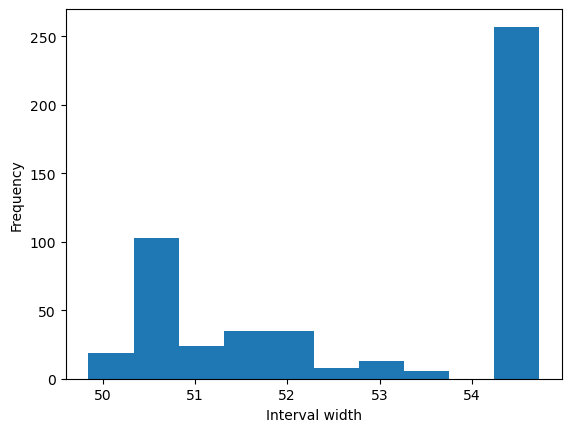

In [160]:
widths = y_qr[:,1] - y_qr[:,0]
plt.hist(widths)
# Label the x-axis
plt.xlabel("Interval width")
# Label the y-axis
plt.ylabel("Frequency")
plt.show()

In [126]:
for i in range(5):
    print("%.3f [%.3f;%.3f]" % (y_pred[i], y_qr[i,0], y_qr[i,1]))

-32.447 [-33.727;1.550]
27.702 [12.330;31.361]
-7.614 [-10.052;1.550]
15.708 [12.330;16.874]
-35.013 [-38.039;1.550]


/tmp/ipykernel_17584/465814403.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("%.3f [%.3f;%.3f]" % (y_pred[i], y_qr[i,0], y_qr[i,1]))


In [127]:
from mapie.metrics import regression_coverage_score
from mapie.metrics import regression_mean_width_score

size = regression_mean_width_score(y_qr[:,0], y_qr[:,1])
print("Average interval width: {:.2f}".format(size))
cov = regression_coverage_score(y_test, y_qr[:,0], y_qr[:,1])
print("Coverage: {:.2%}".format(cov))

Average interval width: 15.71
Coverage: 90.00%


/home/ebezerra/anaconda3/envs/cic1205/lib/python3.12/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


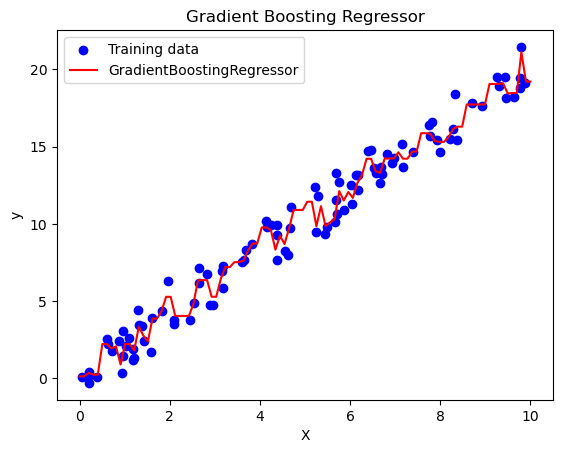

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

# Generate synthetic dataset
np.random.seed(0)
X = np.random.rand(100, 1) * 10  # Generating 100 random numbers between 0 and 10
y = 2 * X.squeeze() + np.random.randn(100)  # Creating target variable with noise

# Fit GradientBoostingRegressor model
gb_model = GradientBoostingRegressor()
gb_model.fit(X, y)

# Plotting the data points
plt.scatter(X, y, color='blue', label='Training data')

# Plotting the model predictions
x_values = np.linspace(0, 10, 100).reshape(-1, 1)
y_pred = gb_model.predict(x_values)
plt.plot(x_values, y_pred, color='red', label='GradientBoostingRegressor')

# Adding labels and legend
plt.xlabel('X')
plt.ylabel('y')
plt.title('Gradient Boosting Regressor')
plt.legend()

# Display the plot
plt.show()
